In [1]:
from IPython.display import Image

| **model** | **heads** | **layers** | **dim** | **head_dim** |
|-----------|-----------|------------|---------|--------------|
| 7b        | 32        | 32         | 4096    | 4096/32      |
| 13b       | 40        | 40         | 5120    | 5120/40      |
| 70b       | 64        | 80         | 8192    | 8192/64      |

- `n_kv_heads = 8`, `n_heads` 都是 8 的倍数

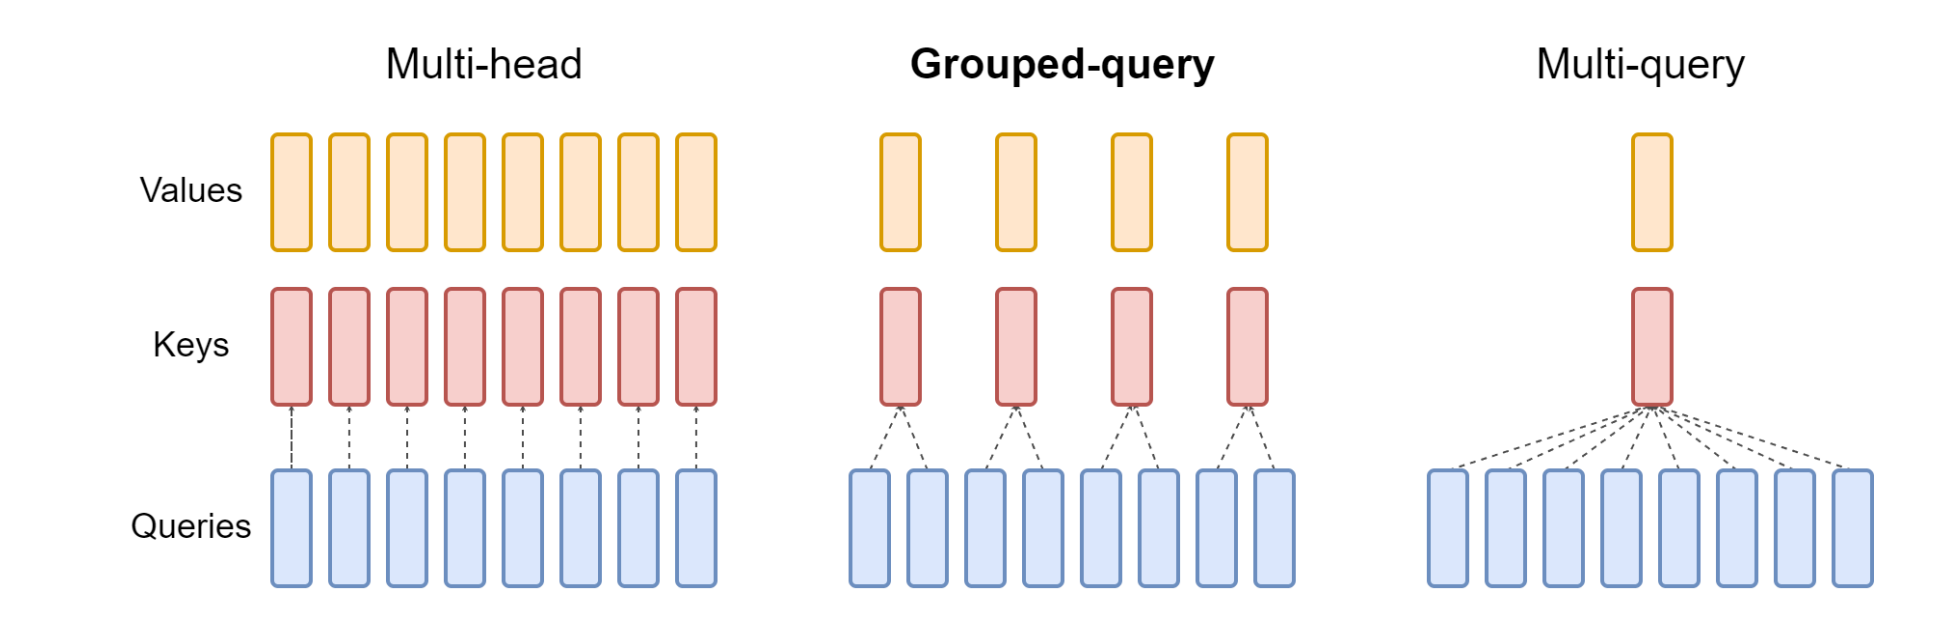

In [2]:
Image('../imgs/gqa.png', width=600)

- multi-head attention (MHA)
    - high quality
    - computationally low
- Grouped query attention (GQA)
    - A good compromise between quality and speed
- Multi-query attention
    - loss in quality
    - computationally fast

- Llama-2 uses GQA to improve the efficiency of attention computation. 
- The GQA model efficiently 
    - breaks the `query` into `n_heads` segments like the original multi-head attention, 
        - `xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)`
    - and the `key` and `value` are divided into `n_kv_heads` groups, enabling multiple key-value heads to share the same query.
        - `xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)`
        - `xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)`
        - `n_kv_heads` 是 70b 才有的参数配置，也就是 7b/13b 没有 GQA
            - `n_kv_heads == 8`
            
- The `query`, `key`, and `value` tensors are prepared for Grouped-Query attention calculation by repeating key-value pairs `n_rep` times, where `n_rep` corresponds to the number of query heads that share the same key-value pair.
    - `self.n_rep = self.n_local_heads // self.n_local_kv_heads`
        - `n_local_heads (int): Number of local query heads.`
        - `n_local_kv_heads (int): Number of local key and value heads.`
        - 其中 `n_heads => n_local_heads` （`model_parallel_size`: mp, 模型的并行度）
            ```
            self.n_local_heads = args.n_heads // model_parallel_size
            self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
            ```